In [1]:
'''
Waterfowl energetics model
October 2023
Mike Mitchell - mmitchell@ducks.org - Ducks Unlimited

Methods

Duckdb

'''
baseaoiurl = 'https://giscog.blob.core.windows.net/waterfowlmodel/'
aois = ['ARmav', 'ARwg', 'KY', 'LAmav', 'LAwg', 'MO', 'MS', 'OK', 'TN', 'TX'] # used to read in files. example: baseaoiurl+aoi+'daily_obj3.csv'

# Habitat curve should be in percentages and max shouldn't be more than 100.
cropcurvedata = {
                    'EmergentWetlands':[19,89,100],
                    'WoodyWetlands':[2,89,100],
                    'OpenWater':[100,100,100],
                    'Sorghum':[3,100,30],
                    'Corn':[3,100,27],
                    'Soybeans':[5,100,38],
                    'Rice':[9,100,39],
                    'Aquaculture':[34,94,100],
                    'Millet':[46,100,95],
                    'Dbl Crop Corn/Soybeans':[2,100,28]
                }
# Decomposition rates as a daily percent decay.  To be calculated by day as leftover = leftover * (100-decay)
cropdecomp = {
                    'EmergentWetlands':0.18,
                    'WoodyWetlands':0.0037,
                    'OpenWater':0,
                    'Sorghum':0.322,
                    'Corn':1.57,
                    'Soybeans':1.9,
                    'Rice':0.213,
                    'Aquaculture':0,
                    'Millet':0.64,
                    'Dbl Crop Corn/Soybeans':1.9
                }
energycsvurl = 'https://giscog.blob.core.windows.net/waterfowlmodel/4D_LMVJV-ST_Obj_FINAL_LONG2.csv'

In [2]:
##########################################
# All config above this line
##########################################

In [3]:
# Checks to make sure habitat curves have at least 3 values and they are not > 100%        
for key,val in cropcurvedata.items():
    if max(val) >100:
        print('Value in {} has a value greater than 100'.format(key))
    if len(val) <3:
        print('Not a great curve with < 3 values for {}'.format(key))            

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sys
import pandas as pd
import json, requests
import geopandas as gpd
import shapely
import duckdb
from shapely import wkt, wkb
#import pygeos as pg

#pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.float_format', lambda x : "{:,.2f}".format(x))

In [5]:
con = duckdb.connect()
con.install_extension("spatial")
con.load_extension("spatial")
con.install_extension("azure")
con.load_extension("azure")

In [6]:
##########################################
#
# Setup done
#
##########################################

In [7]:
con.sql('''
CREATE OR REPLACE TABLE lmvjvwaterfowlenergy AS SELECT * FROM read_parquet('D:\source\waterfowlenergynotebook\lmvjvwaterfowlenergy.parquet')
''')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [8]:
aoiquery = 'https://services2.arcgis.com/5I7u4SJE1vUr79JC/ArcGIS/rest/services/LMVJV_Boundary/FeatureServer/0/query?where=1%3D1&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&relationParam=&returnGeodetic=false&outFields=&returnGeometry=true&returnCentroid=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=5070&defaultSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token='
r = json.dumps(requests.get(aoiquery).json())
aoiresult = gpd.read_file(r)

aoibounds = list(aoiresult.bounds.values[0])
incounty = 'https://services.arcgis.com/P3ePLMYs2RVChkJx/ArcGIS/rest/services/USA_Counties/FeatureServer/0/query?where=1%3D1&objectIds=&time=&geometry={0}&geometryType=esriGeometryEnvelope&inSR=5070&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&relationParam=&returnGeodetic=false&outFields=*&returnGeometry=true&returnCentroid=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=5070&defaultSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token='.format(', '.join(str(a) for a in aoibounds))
r = json.dumps(requests.get(incounty).json())
county = gpd.read_file(r)
county = county[['FIPS','NAME', 'STATE_NAME', 'geometry']]

instate = 'https://services.arcgis.com/P3ePLMYs2RVChkJx/ArcGIS/rest/services/Enriched_USA_States_Generalized_Boundaries/FeatureServer/0/query?where=1%3D1&objectIds=&time=&geometry={0}&geometryType=esriGeometryEnvelope&inSR=5070&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&relationParam=&returnGeodetic=false&outFields=*&returnGeometry=true&returnCentroid=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=5070&defaultSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token='.format(', '.join(str(a) for a in aoibounds))
r = json.dumps(requests.get(instate).json())
state = gpd.read_file(r)

inbcr = 'https://gisweb.ducks.org/server/rest/services/GEODATA/BCR/FeatureServer/0/query?where=1%3D1&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&distance=&units=esriSRUnit_Foot&relationParam=&outFields=*&returnGeometry=true&maxAllowableOffset=&geometryPrecision=&outSR=5070&havingClause=&gdbVersion=&historicMoment=&returnDistinctValues=false&returnIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&multipatchOption=xyFootprint&resultOffset=&resultRecordCount=&returnTrueCurves=false&returnExceededLimitFeatures=false&quantizationParameters=&returnCentroid=false&timeReferenceUnknownClient=false&sqlFormat=none&resultType=&featureEncoding=esriDefault&datumTransformation=&f=geojson'
r = json.dumps(requests.get(inbcr).json())
bcr = gpd.read_file(r)

In [9]:
county['geometry'] = county.to_wkt().geometry
bcr['geometry'] = bcr.to_wkb().geometry

C:\Users\mmitchell.DUCKS\AppData\Local\Temp\ipykernel_22724\4166743715.py:1: UserWarning: Geometry column does not contain geometry.
  county['geometry'] = county.to_wkt().geometry
C:\Users\mmitchell.DUCKS\AppData\Local\Temp\ipykernel_22724\4166743715.py:2: UserWarning: Geometry column does not contain geometry.
  bcr['geometry'] = bcr.to_wkb().geometry


In [10]:
county.columns

Index(['FIPS', 'NAME', 'STATE_NAME', 'geometry'], dtype='object')

In [11]:
con.sql('''CREATE OR REPLACE TABLE cnty AS SELECT * EXCLUDE geometry, ST_GeomFromText(geometry) AS geometry FROM county''')

In [12]:
con.sql('''CREATE OR REPLACE TABLE cnty AS SELECT FIPS, NAME, STATE_NAME, geometry FROM cnty''')

In [13]:
con.sql('''CREATE OR REPLACE TABLE bcr AS SELECT * EXCLUDE geometry, st_geomfromWKB(geometry) as geometry FROM bcr''')
con.sql('''CREATE OR REPLACE TABLE bcr AS SELECT BCR, BCRNAME, geometry FROM bcr''')

In [14]:
con.sql('''CREATE OR REPLACE TABLE statebcr AS 
SELECT NAME, FIPS, STATE_NAME, BCR, BCRNAME, ST_Intersection(cnty.geometry, bcr.geometry) as geometry
FROM cnty
JOIN
bcr ON ST_Intersects(cnty.geometry, bcr.geometry)
''')


In [15]:
con.sql(
    """
        CREATE OR REPLACE TABLE statebcrenergy AS 
        SELECT c.FIPS, c.NAME, c.STATE_NAME, c.BCR, c.BCRNAME, e.CLASS, e.ValueLo, e.ValueHi, ST_Intersection(ST_GeomFromWKB(e.geometry), c.geometry) as geometry
        FROM lmvjvwaterfowlenergy AS e, statebcr AS c
        WHERE ST_Intersects(ST_GeomFromWKB(e.geometry), c.geometry)
    """
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [16]:
##################################################
#
# Continue
#
##################################################
duckdb.__version__

'1.0.0'

In [17]:
# Read in energy layer
#gdf.to_parquet('energylayerintersect.parquet')
inenergyread = con.sql('select * exclude geometry, ST_AsText(geometry) as geometry from statebcrenergy').df()

In [18]:
inenergy = inenergyread.copy()
inenergy['geometry'] = inenergy['geometry'].apply(wkt.loads)
inenergy = gpd.GeoDataFrame(inenergy, geometry='geometry', crs=5070)
inenergy.head()

,FIPS,NAME,STATE_NAME,BCR,BCRNAME,Class,ValueLo,ValueHi,geometry
0,05067,Jackson County,Arkansas,26,MISSISSIPPI ALLUVIAL VALLEY,Woody Wetlands,122,221,"POLYGON ((421575.000 1402185.000, 421575.000 1..."
1,05067,Jackson County,Arkansas,26,MISSISSIPPI ALLUVIAL VALLEY,Herbaceous Wetlands,247,1622,"POLYGON ((422865.000 1402215.000, 422895.000 1..."
2,05067,Jackson County,Arkansas,26,MISSISSIPPI ALLUVIAL VALLEY,Woody Wetlands,122,221,"POLYGON ((428355.000 1402215.000, 428355.596 1..."
3,05067,Jackson County,Arkansas,26,MISSISSIPPI ALLUVIAL VALLEY,Soybeans,937,3410,"POLYGON ((437325.000 1402214.299, 437325.000 1..."
4,05067,Jackson County,Arkansas,26,MISSISSIPPI ALLUVIAL VALLEY,Soybeans,937,3410,"POLYGON ((437385.000 1402214.299, 437385.000 1..."


In [19]:
inenergy = inenergy.rename(columns={'Class':'CLASS'})
inenergy.head()

,FIPS,NAME,STATE_NAME,BCR,BCRNAME,CLASS,ValueLo,ValueHi,geometry
0,05067,Jackson County,Arkansas,26,MISSISSIPPI ALLUVIAL VALLEY,Woody Wetlands,122,221,"POLYGON ((421575.000 1402185.000, 421575.000 1..."
1,05067,Jackson County,Arkansas,26,MISSISSIPPI ALLUVIAL VALLEY,Herbaceous Wetlands,247,1622,"POLYGON ((422865.000 1402215.000, 422895.000 1..."
2,05067,Jackson County,Arkansas,26,MISSISSIPPI ALLUVIAL VALLEY,Woody Wetlands,122,221,"POLYGON ((428355.000 1402215.000, 428355.596 1..."
3,05067,Jackson County,Arkansas,26,MISSISSIPPI ALLUVIAL VALLEY,Soybeans,937,3410,"POLYGON ((437325.000 1402214.299, 437325.000 1..."
4,05067,Jackson County,Arkansas,26,MISSISSIPPI ALLUVIAL VALLEY,Soybeans,937,3410,"POLYGON ((437385.000 1402214.299, 437385.000 1..."


In [20]:
'''
Prep energy layer so we can calculate total energy at the county level.  Remove NAN
'''
#inenergy = inenergy.set_crs(5070)
inenergy['acres'] = inenergy.area* 0.000247105
inenergy.loc[inenergy.CLASS=='Woody Wetlands', ['CLASS']] = 'WoodyWetlands'
inenergy.loc[inenergy.CLASS=='Open Water', ['CLASS']] = 'OpenWater'
inenergy.loc[inenergy.CLASS=='Herbaceous Wetlands', ['CLASS']] = 'EmergentWetlands'
inenergy = inenergy.drop(['geometry'], axis=1)
inenergy = inenergy.groupby(['FIPS','NAME','STATE_NAME','BCR','BCRNAME','CLASS','ValueLo','ValueHi']).sum()
inenergy = inenergy.reset_index()
inenergy = inenergy[inenergy['NAME']!='NaN']
inenergy.loc[(inenergy['STATE_NAME']=='Arkansas') & (inenergy['BCRNAME']=='MISSISSIPPI ALLUVIAL VALLEY'), ['statebcr']] = 'Arkansas_mav'
inenergy.loc[(inenergy['STATE_NAME']=='Arkansas') & (inenergy['BCRNAME']=='WEST GULF COASTAL PLAIN/OUACHITAS'), ['statebcr']] = 'Arkansas_wg'
inenergy.loc[(inenergy['STATE_NAME']=='Louisiana') & (inenergy['BCRNAME']=='MISSISSIPPI ALLUVIAL VALLEY'), ['statebcr']] = 'Louisiana_mav'
inenergy.loc[(inenergy['STATE_NAME']=='Louisiana') & (inenergy['BCRNAME']=='WEST GULF COASTAL PLAIN/OUACHITAS'), ['statebcr']] = 'Louisiana_wg'
inenergy.loc[~inenergy['STATE_NAME'].isin(['Arkansas', 'Louisiana']), ['statebcr']] = inenergy['STATE_NAME']
inenergy = inenergy.drop(['STATE_NAME','BCR','BCRNAME'], axis=1)

C:\Users\mmitchell.DUCKS\AppData\Local\Temp\ipykernel_22724\4131605805.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Arkansas_mav' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inenergy.loc[(inenergy['STATE_NAME']=='Arkansas') & (inenergy['BCRNAME']=='MISSISSIPPI ALLUVIAL VALLEY'), ['statebcr']] = 'Arkansas_mav'


In [21]:
print('Habitat acres: {0:,.0f}'.format(inenergy['acres'].sum()))
print('DEDs: {0:,.0f}'.format((inenergy['acres']*inenergy['ValueHi']).sum()))

Habitat acres: 6,758,185
DEDs: 16,275,689,198


In [22]:
# Read population objectives
popobjtable = pd.read_csv(energycsvurl)
popobjtable = popobjtable.rename(columns={'State':'state', 'LMVJV.80P.OBJ':'popobj80'})
print('Max population objective: {0:,.0f}'.format(popobjtable['popobj80'].max()))

Max population objective: 2,672,079


In [23]:
# Read waterfowl curves and adjust attributes to align with long term objectives by statebcr
mergecurve = pd.DataFrame()
for aoi in aois:
    incsv = pd.read_csv(baseaoiurl+aoi+'daily_obj3.csv')
    mergecurve = pd.concat([mergecurve, incsv])
mergecurve = mergecurve.rename(columns={'ST':'state','SP2':'species'})
mergecurve.loc[mergecurve.state=='ARmav', ['state']] = 'Arkansas_mav'
mergecurve.loc[mergecurve.state=='ARwg', ['state']] = 'Arkansas_wg'
mergecurve.loc[mergecurve.state=='KY', ['state']] = 'Kentucky'
mergecurve.loc[mergecurve.state=='LAwg', ['state']] = 'Louisiana_wg'
mergecurve.loc[mergecurve.state=='LAmav', ['state']] = 'Louisiana_mav'
mergecurve.loc[mergecurve.state=='MO', ['state']] = 'Missouri'
mergecurve.loc[mergecurve.state=='MS', ['state']] = 'Mississippi'
mergecurve.loc[mergecurve.state=='OK', ['state']] = 'Oklahoma'
mergecurve.loc[mergecurve.state=='TN', ['state']] = 'Tennessee'
mergecurve.loc[mergecurve.state=='TX', ['state']] = 'Texas'

In [28]:
# Merge population objectives and waterfowl curves.  Scale curves so the population objective is the max on the curve.
curvetable = pd.merge(mergecurve, popobjtable, on=('state', 'species'), how='left')
curvetable['max'] = curvetable.select_dtypes(include=[np.float64]).drop(columns=['popobj80']).max(axis=1)
curvetable = curvetable[curvetable['popobj80']>0]
curvetable['scale'] = curvetable['popobj80']/curvetable['max']
display(curvetable)
newtable = curvetable[curvetable.select_dtypes(include=['float64']).columns].multiply(curvetable['scale'],axis='index')
#newtable = newtable.drop(columns=['popobj80', 'max', 'scale'])
display(newtable)
newtable = newtable.drop(columns=['popobj80', 'scale'])
curvetable.update(newtable)
#curvetable = curvetable.rename(columns={'Unnamed: 0':'0'})
curvetable = curvetable.drop(['Unnamed: 0'], axis=1)
#curvetable['0'] = 0

,Unnamed: 0,state,species,1,2,3,4,5,6,7,...,222,223,224,225,226,227,228,popobj80,max,scale
0,1,Arkansas_mav,AGWT,2.09,2.93,3.34,3.46,3.44,3.41,3.52,...,"564,909.23","534,460.02","503,645.91","472,632.48","441,585.34","410,670.08","380,052.28","357,194.98","854,446.26",0.42
1,2,Arkansas_mav,AMWI,0.30,0.00,0.00,0.00,0.00,0.00,0.00,...,"138,948.35","124,024.85","112,714.69","105,487.23","102,811.85","105,157.92","112,994.81","112,702.38","484,259.48",0.23
2,3,Arkansas_mav,BWTE,"850,241.17","870,128.34","936,440.81","1,046,143.46","1,196,201.17","1,383,578.80","1,605,241.23",...,"5,423,208.37","5,779,951.54","6,116,805.65","6,429,739.78","6,714,723.00","6,967,724.41","7,184,713.07","5,284.50","13,554,493.88",0.00
3,4,Arkansas_mav,CANV,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,"5,041.59",344.59,0.00,"1,733.94","8,658.58","20,295.38","37,063.48","13,658.78","182,497.96",0.07
4,5,Arkansas_mav,GADW,320.84,350.80,371.13,382.85,387.00,384.62,376.72,...,"369,619.43","348,894.82","330,358.49","314,390.96","301,372.76","291,684.42","285,706.47","466,386.81","659,831.23",0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,8,Texas,NSHO,0.00,0.00,4.59,8.84,12.82,16.57,20.14,...,"29,170.85","27,763.02","26,381.48","25,034.99","23,732.32","22,482.25","21,293.54","20,680.00","49,440.12",0.42
116,9,Texas,REDH,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,82.30,"1,232.10","2,865.10","6,491.00","22,654.52",0.29
117,10,Texas,RNDU,0.03,0.00,0.00,0.00,0.00,0.00,0.00,...,"8,818.26","7,566.54","6,649.31","6,106.98","5,979.95","6,308.62","7,133.38","41,027.00","52,953.30",0.77
118,11,Texas,SCAU,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,"64,352.48","58,380.64","53,638.08","50,259.22","48,378.48","48,130.29","49,649.07","107,668.00","240,434.61",0.45


,1,2,3,4,5,6,7,8,9,10,...,222,223,224,225,226,227,228,popobj80,max,scale
0,0.88,1.22,1.39,1.45,1.44,1.43,1.47,1.63,1.96,2.50,...,"236,156.15","223,427.08","210,545.47","197,580.54","184,601.51","171,677.61","158,878.06","149,322.73","357,194.98",0.17
1,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.07,...,"32,337.64","28,864.48","26,232.25","24,550.19","23,927.55","24,473.55","26,297.44","26,229.38","112,702.38",0.05
2,331.48,339.24,365.09,407.86,466.36,539.42,625.84,724.44,834.04,953.46,...,"2,114.35","2,253.43","2,384.76","2,506.76","2,617.87","2,716.51","2,801.11",2.06,"5,284.50",0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,377.33,25.79,0.00,129.77,648.04,"1,518.98","2,773.96","1,022.27","13,658.78",0.01
4,226.78,247.96,262.32,270.61,273.55,271.86,266.28,257.53,246.36,233.54,...,"261,257.15","246,608.43","233,506.44","222,220.15","213,018.53","206,170.55","201,945.17","329,654.98","466,386.81",0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.00,0.00,1.92,3.70,5.36,6.93,8.43,9.87,11.28,12.70,...,"12,201.69","11,612.82","11,034.94","10,471.73","9,926.84","9,403.96","8,906.74","8,650.11","20,680.00",0.17
116,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,23.58,353.02,820.91,"1,859.81","6,491.00",0.08
117,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,...,"6,832.19","5,862.38","5,151.73","4,731.55","4,633.13","4,887.77","5,526.78","31,786.78","41,027.00",0.60
118,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,"28,817.41","26,143.19","24,019.44","22,506.37","21,664.16","21,553.02","22,233.14","48,214.35","107,668.00",0.20


In [29]:
#curvetable = curvetable.drop(columns=['max', 'scale', 'popobj80'])
curvetable = curvetable.drop(columns=['scale', 'popobj80'])
curvetable = curvetable.rename(columns={'state':'statebcr'})

In [30]:
# Read in decomp
indecomp = pd.DataFrame.from_dict(cropdecomp,orient='index', columns=['decomp'])
indecomp = indecomp.reset_index()
indecomp = indecomp.rename(columns={'index':'CLASS'})
inenergy = inenergy.merge(indecomp, on='CLASS', how='left')
inenergy.head()

,FIPS,NAME,CLASS,ValueLo,ValueHi,acres,statebcr,decomp
0,05001,Arkansas County,Aquaculture,3,1954,0.44,Arkansas_mav,0.00
1,05001,Arkansas County,Corn,1130,22530,"3,716.00",Arkansas_mav,1.57
2,05001,Arkansas County,EmergentWetlands,247,1622,112.65,Arkansas_mav,0.18
3,05001,Arkansas County,Millet,0,937,3.11,Arkansas_mav,0.64
4,05001,Arkansas County,OpenWater,3,3,"14,254.10",Arkansas_mav,0.00


In [31]:
curvetable

,statebcr,species,1,2,3,4,5,6,7,8,...,220,221,222,223,224,225,226,227,228,max
0,Arkansas_mav,AGWT,0.88,1.22,1.39,1.45,1.44,1.43,1.47,1.63,...,"260,879.75","248,663.45","236,156.15","223,427.08","210,545.47","197,580.54","184,601.51","171,677.61","158,878.06","357,194.98"
1,Arkansas_mav,AMWI,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,"41,369.84","36,542.51","32,337.64","28,864.48","26,232.25","24,550.19","23,927.55","24,473.55","26,297.44","112,702.38"
2,Arkansas_mav,BWTE,331.48,339.24,365.09,407.86,466.36,539.42,625.84,724.44,...,"1,819.20","1,969.08","2,114.35","2,253.43","2,384.76","2,506.76","2,617.87","2,716.51","2,801.11","5,284.50"
3,Arkansas_mav,CANV,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,"1,730.63",956.07,377.33,25.79,0.00,129.77,648.04,"1,518.98","2,773.96","13,658.78"
4,Arkansas_mav,GADW,226.78,247.96,262.32,270.61,273.55,271.86,266.28,257.53,...,"294,118.92","277,183.64","261,257.15","246,608.43","233,506.44","222,220.15","213,018.53","206,170.55","201,945.17","466,386.81"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,Texas,NSHO,0.00,0.00,1.92,3.70,5.36,6.93,8.43,9.87,...,"13,397.74","12,797.89","12,201.69","11,612.82","11,034.94","10,471.73","9,926.84","9,403.96","8,906.74","20,680.00"
116,Texas,REDH,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,366.53,85.71,0.00,0.00,0.00,0.00,23.58,353.02,820.91,"6,491.00"
117,Texas,RNDU,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,"9,424.10","8,029.86","6,832.19","5,862.38","5,151.73","4,731.55","4,633.13","4,887.77","5,526.78","41,027.00"
118,Texas,SCAU,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,"35,576.52","31,981.92","28,817.41","26,143.19","24,019.44","22,506.37","21,664.16","21,553.02","22,233.14","107,668.00"


In [67]:
0%4

0

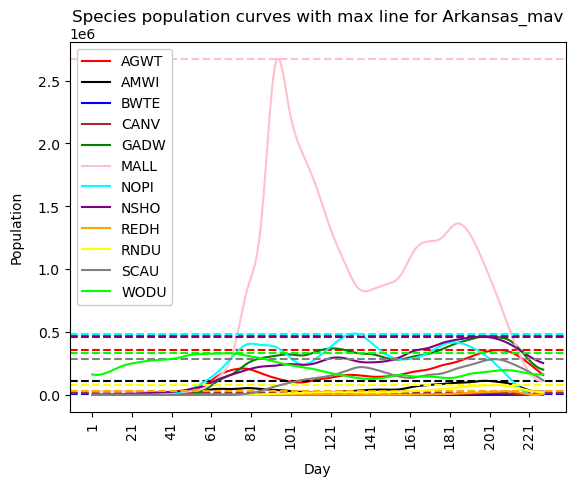

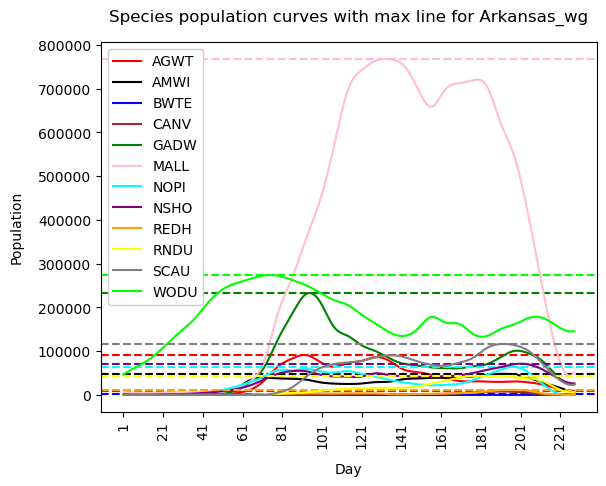

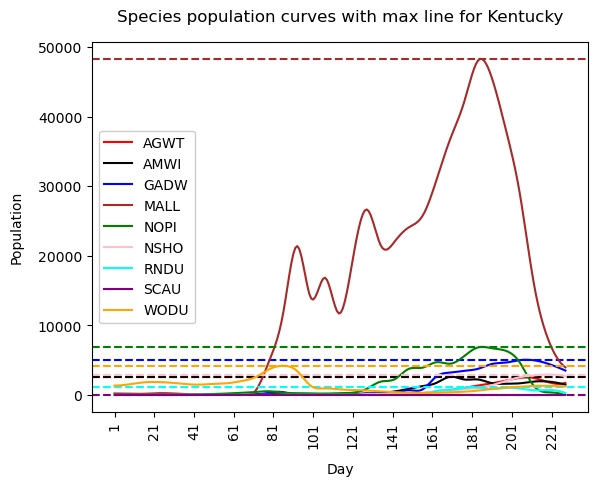

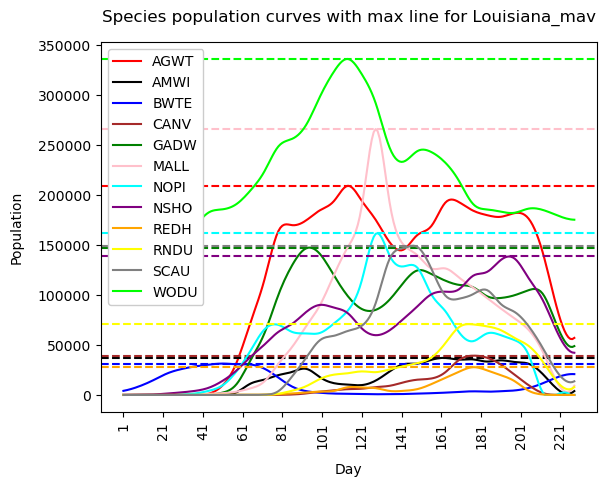

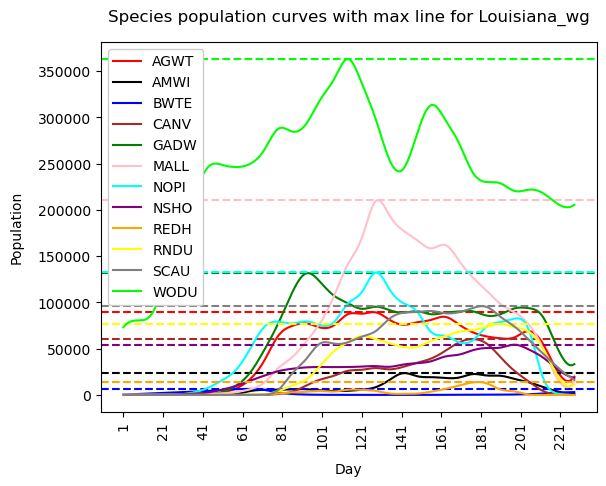

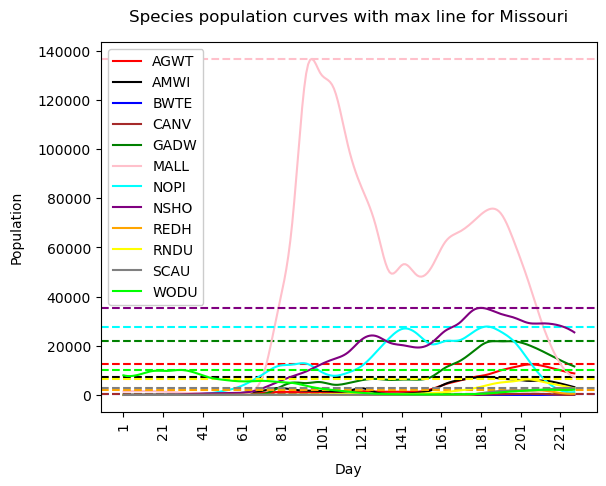

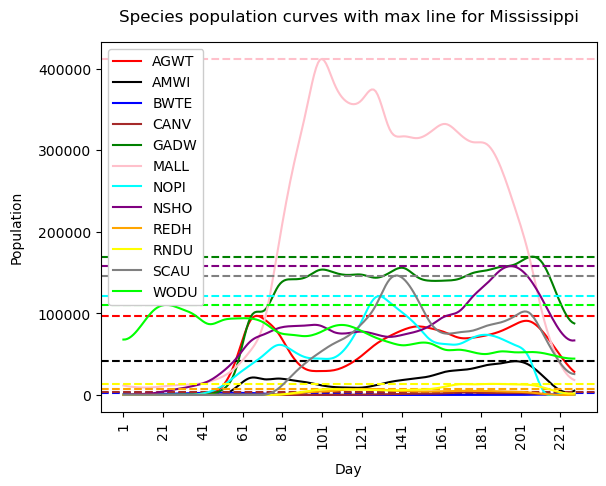

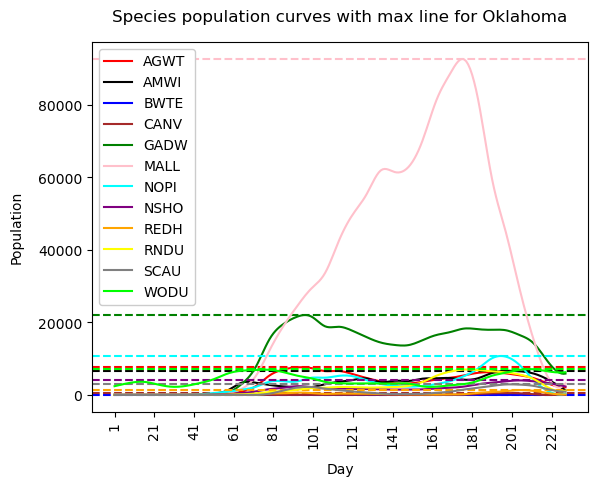

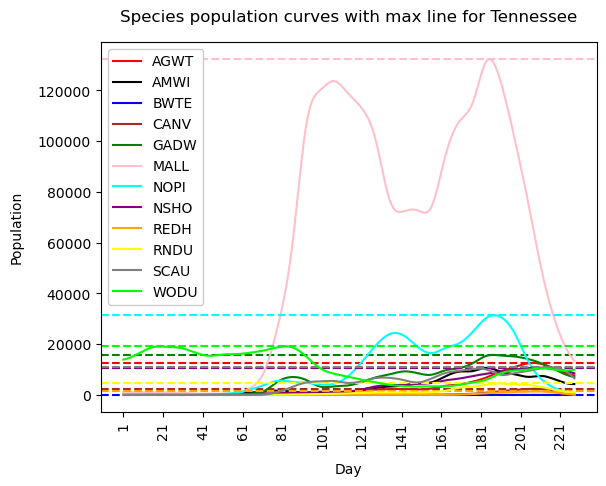

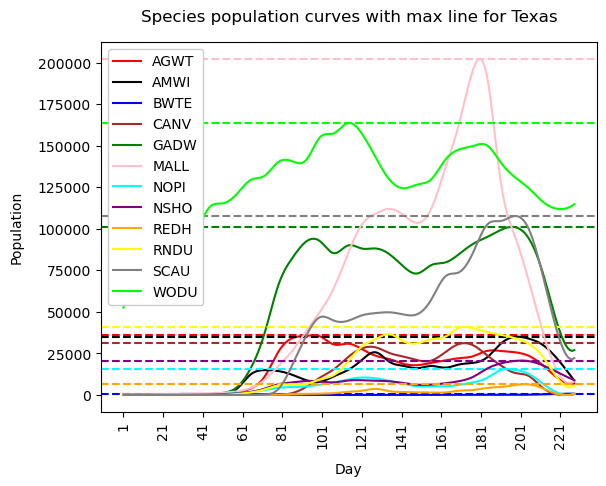

In [77]:
# Plot by species
curvetable = curvetable.replace([np.inf, -np.inf], np.nan).fillna(0)
colors=['red', 'black', 'blue', 'brown', 'green', 'pink', 'cyan', 'purple', 'orange', 'yellow', 'grey', 'lime']
sq = int(math.sqrt(len(curvetable['statebcr'].unique()))+1)
a=0
c=0
d=0
for stbcr in curvetable['statebcr'].unique():
    i=0
    for sp in curvetable['species'].unique():
        #print(sp, i)
        ct = curvetable[curvetable['statebcr']==stbcr]
        tmp = ct.drop(columns='max').groupby('species').sum().drop(columns='statebcr')
        maxsp = ct[['statebcr', 'max', 'species']].groupby('species').sum().drop(columns='statebcr')
        maxsp = maxsp.reset_index()
        maxsp = maxsp[maxsp['species']==sp]
        tmp = tmp.reset_index()
        tmp = tmp[tmp['species']==sp]
        tmp = tmp.drop(['species'], axis=1).transpose().reset_index()
        try:
            plt.plot(tmp['index'],tmp[i], color=colors[i], label=sp)
            plt.axhline(y = maxsp['max'][i], color=colors[i], linestyle = '--', label='_') 
        except:
            continue
        i+=1
    plt.legend(framealpha=1)
    plt.xticks(np.arange(0, 230, step=20), rotation='vertical')
    plt.title('Species population curves with max line for {0}'.format(stbcr), pad=15)
    plt.xlabel('Day', labelpad=10)
    plt.ylabel('Population', labelpad=10)
    plt.show()

In [29]:
curvetable = curvetable.groupby(['statebcr']).sum().reset_index().drop(['Unnamed: 0'], axis=1)

In [30]:
curvetable = curvetable.drop(columns='species')
#curvetable[(curvetable['statebcr']=='Arkansas_mav')].drop(columns=['statebcr']).transpose().max()

In [31]:
curvetable = curvetable.replace([np.inf, -np.inf], np.nan).fillna(0)
curvetable.head()

,statebcr,1,2,3,4,5,6,7,8,9,...,219,220,221,222,223,224,225,226,227,228
0,Arkansas_mav,"195,864.62","192,728.41","191,437.96","191,836.07","193,765.62","197,069.47","201,590.50","207,171.56","213,655.54",...,"1,642,024.58","1,542,868.70","1,450,367.23","1,365,763.27","1,292,937.83","1,228,214.37","1,172,358.04","1,131,184.32","1,104,714.28","1,093,600.30"
1,Arkansas_wg,"53,619.60","56,417.81","59,130.01","61,736.22","64,259.08","66,721.20","69,145.22","71,553.76","73,969.44",...,"440,945.53","405,645.50","374,034.44","346,585.69","324,069.78","306,624.77","294,344.07","288,020.53","288,911.60","297,383.80"
2,Kentucky,"1,563.26","1,564.08","1,572.12","1,586.52","1,606.59","1,631.60","1,660.87","1,693.67","1,729.31",...,"21,883.85","20,928.55","20,027.62","19,175.14","18,365.13","17,591.67","16,848.80","16,130.57","15,431.04","14,881.49"
3,Louisiana_mav,"113,122.59","114,830.21","116,217.52","117,314.12","118,171.26","118,840.21","119,372.21","119,818.52","120,230.39",...,"479,872.37","454,742.05","432,025.11","412,108.69","395,379.93","382,225.95","373,033.89","368,190.88","370,474.45","378,819.02"
4,Louisiana_wg,"74,498.21","76,910.94","78,744.27","80,063.81","80,960.59","81,532.98","81,868.93","82,058.43","82,192.13",...,"399,520.10","378,333.06","359,484.00","343,334.07","330,244.43","320,576.25","314,690.89","312,948.89","316,073.85","324,233.57"


Text(0.5, 1.0, 'Demand by statebcr')

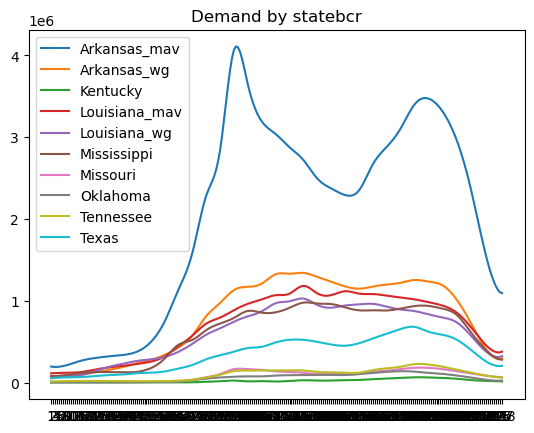

In [32]:
# sum energy demand by statebcr, removing species.
#display(curvetable.head())
i=0
for st in curvetable['statebcr'].unique():
    query = pd.DataFrame(curvetable[curvetable['statebcr']==st]).drop('statebcr',axis=1).transpose().reset_index()
    plt.plot(query['index'], query[i])
    i+=1
plt.legend(curvetable['statebcr'].unique())    
plt.title('Demand by statebcr')

Index(['index', 0], dtype='object')


Text(0.5, 1.0, 'Demand')

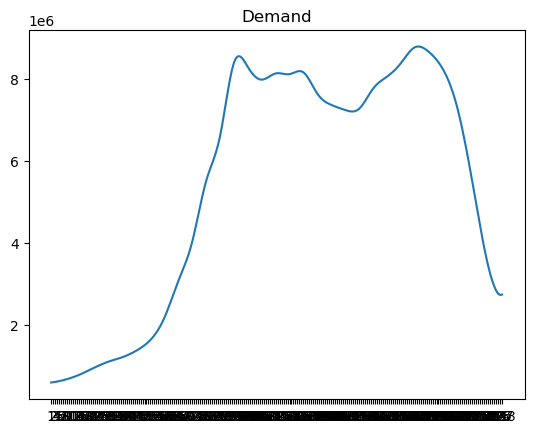

In [33]:
totaldemand = curvetable.sum().reset_index().drop([0])
print(totaldemand.columns)
plt.plot(totaldemand['index'], totaldemand[0])
plt.title('Demand')

Text(0, 0.5, '% available')

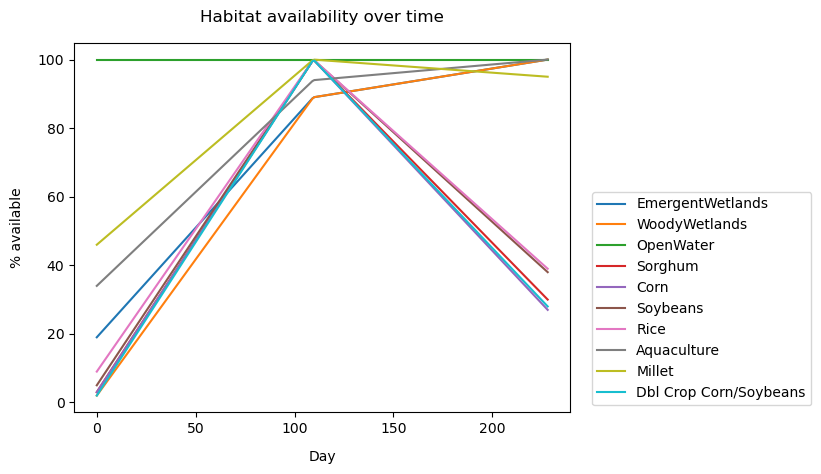

In [151]:
# Calculate habitat curves
habitatcurvedata = {}
for sp in cropcurvedata.keys():
    habitatcurvedata[sp] = np.interp(np.linspace(0, 229, 229), [0,110,229], cropcurvedata[sp])
    if max(habitatcurvedata[sp]) > 1:
        habitatcurvedata[sp] = habitatcurvedata[sp]/100
habitatcurve = pd.DataFrame.from_dict(habitatcurvedata).transpose().reset_index().rename(columns={'index':'CLASS'})
for sp in cropcurvedata.keys():
    model = habitatcurvedata[sp]
    plt.plot(model*100, label=sp)
    plt.legend(loc='lower right',bbox_to_anchor=(1.5, 0))
plt.title('Habitat availability over time', pad=15)
plt.xlabel('Day', labelpad=10)
plt.ylabel('% available', labelpad=10)    

In [35]:
inenergy = inenergy.dropna(subset=['statebcr'])
display(inenergy.head())
display(inenergy['statebcr'].unique())

,FIPS,NAME,CLASS,ValueLo,ValueHi,acres,statebcr,decomp
0,05001,Arkansas County,Aquaculture,3,1954,0.44,Arkansas_mav,0.00
1,05001,Arkansas County,Corn,1130,22530,"3,716.00",Arkansas_mav,1.57
2,05001,Arkansas County,EmergentWetlands,247,1622,112.65,Arkansas_mav,0.18
3,05001,Arkansas County,Millet,0,937,3.11,Arkansas_mav,0.64
4,05001,Arkansas County,OpenWater,3,3,"14,254.10",Arkansas_mav,0.00


array(['Arkansas_mav', 'Arkansas_wg', 'Illinois', 'Kentucky',
       'Louisiana_wg', 'Louisiana_mav', 'Mississippi', 'Missouri',
       'Oklahoma', 'Tennessee', 'Texas'], dtype=object)

In [36]:
# testing daily iteration and aggregation
trackenergy = pd.DataFrame() # create empty dataframe to hold output by day
energylayer = inenergy.copy().fillna(0)
energylayer['unique'] = energylayer.index
energylayer['vegenergyprevLo'] = 0
energylayer['vegenergyprevHi'] = 0
energylayer['leftoverLo'] = 0
energylayer['leftoverHi'] = 0
trackhideficit = pd.DataFrame()
tracklodeficit = pd.DataFrame()
for i in range(1,229): #1 to 228
    energylayer['day'] = i
    
    # Get habitat availability based on habitat curve and calculate available acres
    hab = habitatcurve[['CLASS', i]] # select habitat availability curve for day by class
    energylayer = energylayer.merge(hab, on='CLASS', how='left') # merge habitat curve to the energy layer
    energylayer['habpct'] = energylayer[i]
    energylayer = energylayer.drop(i, axis=1) # Drop habitat percentage day column
    energylayer['availacres']= energylayer['acres'] * energylayer['habpct']# calculate available acres which is acres of the energy polygon * habitat type availability for that day.
    
    # Calculate energy supply
    energylayer['vegenergyLo'] = energylayer['availacres'] * energylayer['ValueLo']
    energylayer['vegenergyHi'] = energylayer['availacres'] * energylayer['ValueHi']
    energylayer['supplyLo'] = energylayer['vegenergyLo'] - energylayer['vegenergyprevLo'] # Energy supply includes the leftover energy from the day before plus the difference between todays supply energy and yesterdays.
    energylayer['supplyHi'] = energylayer['vegenergyHi'] - energylayer['vegenergyprevHi']
    energylayer['vegenergyprevLo'] = energylayer['vegenergyLo']
    energylayer['vegenergyprevHi'] = energylayer['vegenergyHi']     
    
    # Add supply from previous day
    energylayer['supplyLo'] = energylayer['supplyLo'] + energylayer['leftoverLo']
    energylayer['supplyHi'] = energylayer['supplyHi'] + energylayer['leftoverHi']
    
    # supply can't be less than 0
    #energylayer.loc[energylayer['supplyLo']<0,['supplyLo']] = 0
    #energylayer.loc[energylayer['supplyHi']<0,['supplyHi']] = 0
    
    # Proportion demand based on energy supply at the county level
    energylayerbystatebcr = energylayer[['statebcr','supplyLo', 'supplyHi']].groupby(['statebcr']).sum().rename(columns={'supplyLo':'supplyLoMax', 'supplyHi':'supplyHiMax'})
    for a in ('supplyLoMax', 'supplyHiMax'):
        if a in energylayer.columns:
            energylayer = energylayer.drop(a, axis=1)
    energylayer = energylayer.merge(energylayerbystatebcr, on='statebcr', how='left')
    energylayer['pctdemand'] = energylayer['supplyHi']/energylayer['supplyHiMax']
    energylayer.loc[np.isnan(energylayer['pctdemand']),['pctdemand']] = 0
    popcurve = curvetable[['statebcr', str(i)]] # select demand for the day based on curve.
    energylayer = energylayer.merge(popcurve, on='statebcr', how='left') # merge demand for that day based on statebcr
    energylayer['demand'] = energylayer['pctdemand']*energylayer[str(i)]
    
    # Calculate leftover energy
    energylayer['leftoverLo'] = energylayer['supplyLo'] - energylayer['demand']
    energylayer['leftoverHi'] = energylayer['supplyHi'] - energylayer['demand']
    
    # Decomp
    energylayer['leftoverLo'] = energylayer['leftoverLo'] * ((100-energylayer['decomp'])*.01)
    energylayer['leftoverHi'] = energylayer['leftoverHi'] * ((100-energylayer['decomp'])*.01)
    
    # Fix <0 and drop population curve day column
    energylayer = energylayer.drop(str(i), axis=1)
    #energylayer.loc[np.isnan(energylayer['leftoverLo']),['leftoverLo']] = 0
    #energylayer.loc[np.isnan(energylayer['leftoverHi']),['leftoverHi']] = 0

    trackenergy = pd.concat([trackenergy, energylayer])
    tracklodeficit = pd.concat([tracklodeficit,energylayer[['day','statebcr','leftoverLo']].groupby(['day','statebcr']).sum().reset_index()])
    trackhideficit = pd.concat([trackhideficit,energylayer[['day','statebcr','leftoverHi']].groupby(['day','statebcr']).sum().reset_index()])

In [37]:
energylayer.head()
#popcurve = curvetable[['statebcr', str(1)]] # select demand for the day based on curve.
#trackenergy = trackenergy[trackenergy['statebcr'] != 0]
#display(trackenergy[['day', 'statebcr','demandLo']].loc[trackenergy['day']==1].groupby(['day', 'statebcr']).sum())
#display(popcurve)
#display(trackenergy[trackenergy['day']==1].groupby(['statebcr']).sum())
#display(trackenergy[['day', 'supplyLo', 'statebcr']].groupby(['day', 'statebcr']).sum())

,FIPS,NAME,CLASS,ValueLo,ValueHi,acres,statebcr,decomp,unique,vegenergyprevLo,...,habpct,availacres,vegenergyLo,vegenergyHi,supplyLo,supplyHi,pctdemand,demand,supplyLoMax,supplyHiMax
0,05001,Arkansas County,Aquaculture,3,1954,0.44,Arkansas_mav,0.00,0,1.33,...,1.00,0.44,1.33,869.12,-232.96,634.83,-0.00,-10.61,"-438,559,379.93","-65,425,916.37"
1,05001,Arkansas County,Corn,1130,22530,"3,716.00",Arkansas_mav,1.57,1,"1,133,750.16",...,0.27,"1,003.32","1,133,750.16","22,604,770.91","2,230,186.19","-18,461,003.35",0.28,"308,577.39","-438,559,379.93","-65,425,916.37"
2,05001,Arkansas County,EmergentWetlands,247,1622,112.65,Arkansas_mav,0.18,2,"27,824.80",...,1.00,112.65,"27,824.80","182,719.97","-14,910.89","99,554.99",-0.00,"-1,664.07","-438,559,379.93","-65,425,916.37"
3,05001,Arkansas County,Millet,0,937,3.11,Arkansas_mav,0.64,3,0.00,...,0.95,2.96,0.00,"2,771.50",-210.22,530.19,-0.00,-8.86,"-438,559,379.93","-65,425,916.37"
4,05001,Arkansas County,OpenWater,3,3,"14,254.10",Arkansas_mav,0.00,4,"42,762.30",...,1.00,"14,254.10","42,762.30","42,762.30","30,842.50","30,842.50",-0.00,-515.54,"-438,559,379.93","-65,425,916.37"


In [38]:
print(len(trackenergy))
#sample = trackenergy[trackenergy['day']>200]
#sample['reduction'] = sample['supplyLo'] - sample['demand']
#sample[['day', 'supplyLo', 'demand', 'reduction','leftoverLo']].groupby(['day']).sum()

383268


In [39]:
sample = trackenergy[trackenergy['day']==220]
printme = sample[['statebcr','CLASS', 'supplyLo', 'demand', 'leftoverLo']].groupby(['statebcr','CLASS']).sum()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(printme)
printme = printme.reset_index()

                                            supplyLo        demand  \
statebcr      CLASS                                                  
Arkansas_mav  Aquaculture                -144,546.27      4,157.31   
              Corn                      3,371,346.60   -982,984.30   
              EmergentWetlands           -263,466.43     66,907.78   
              Millet                       -3,486.48         91.87   
              OpenWater                -1,827,362.24     65,889.84   
              Rice                   -326,115,741.04  4,611,013.18   
              Sorghum                     -29,057.76        -29.92   
              Soybeans                -80,612,440.03 -2,287,844.54   
              WoodyWetlands             4,844,504.10     65,667.47   
Arkansas_wg   Aquaculture                  -4,623.81        -17.85   
              Corn                      2,788,950.74    278,391.67   
              EmergentWetlands        -37,707,748.07   -210,667.27   
              Millet

Text(0.5, 1.0, 'Leftover low by statebcr')

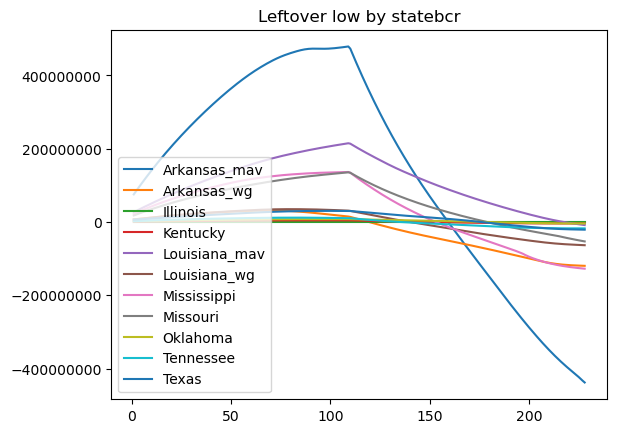

In [40]:
'''
plt.plot(list(range(1,229)),trackhideficit)
plt.plot(list(range(1,229)),tracklodeficit)
plt.title('Energy deficit over time')
plt.legend(['High', 'Low'])
'''
tracklodeficit = tracklodeficit[tracklodeficit['statebcr'] != 0]
#tracklodeficit = tracklodeficit[tracklodeficit['statebcr'] != 'Kentucky']
for st in tracklodeficit['statebcr'].unique():
    query = tracklodeficit[tracklodeficit['statebcr']==st].drop(['statebcr'],axis=1)
    plt.plot(query[['day']], query[['leftoverLo']])
plt.legend(tracklodeficit['statebcr'].unique())
plt.ticklabel_format(style='plain')
plt.title('Leftover low by statebcr')

Text(0.5, 1.0, 'Leftover hi by statebcr')

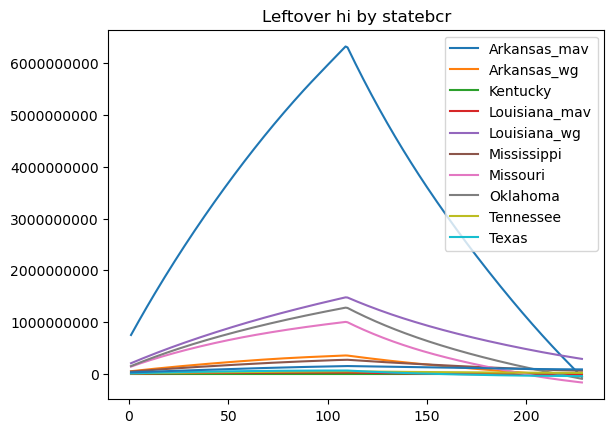

In [41]:
i=0
for st in trackhideficit['statebcr'].unique():
    query = trackhideficit[trackhideficit['statebcr']==st].drop(['statebcr'],axis=1)
    plt.plot(query['day'], query['leftoverHi'])
    i+=1
plt.legend(curvetable['statebcr'].unique())
plt.ticklabel_format(style='plain')
plt.title('Leftover hi by statebcr')

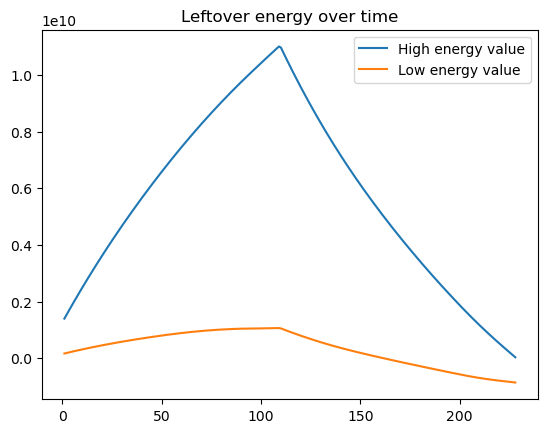

In [42]:
plt.plot(list(range(1,229)),trackenergy[['day','leftoverHi']].groupby(['day']).sum().reset_index()['leftoverHi'])
plt.plot(list(range(1,229)),trackenergy[['day','leftoverLo']].groupby(['day']).sum().reset_index()['leftoverLo'])
plt.title('Leftover energy over time')
plt.legend(['High energy value', 'Low energy value'])

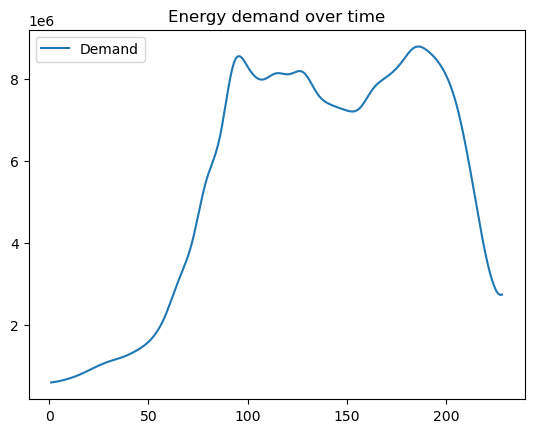

In [43]:
plt.plot(list(range(1,229)),trackenergy[['day','demand']].groupby(['day']).sum().reset_index()['demand'])
plt.title('Energy demand over time')
plt.legend(['Demand'])

In [44]:
trackenergy.head()

,FIPS,NAME,CLASS,ValueLo,ValueHi,acres,statebcr,decomp,unique,vegenergyprevLo,...,habpct,availacres,vegenergyLo,vegenergyHi,supplyLo,supplyHi,supplyLoMax,supplyHiMax,pctdemand,demand
0,05001,Arkansas County,Aquaculture,3,1954,0.44,Arkansas_mav,0.00,0,0.46,...,0.35,0.15,0.46,300.26,0.46,300.26,"76,231,026.21","755,111,806.12",0.00,0.08
1,05001,Arkansas County,Corn,1130,22530,"3,716.00",Arkansas_mav,1.57,1,"163,162.85",...,0.04,144.39,"163,162.85","3,253,149.54","163,162.85","3,253,149.54","76,231,026.21","755,111,806.12",0.00,843.82
2,05001,Arkansas County,EmergentWetlands,247,1622,112.65,Arkansas_mav,0.18,2,"5,464.56",...,0.20,22.12,"5,464.56","35,884.66","5,464.56","35,884.66","76,231,026.21","755,111,806.12",0.00,9.31
3,05001,Arkansas County,Millet,0,937,3.11,Arkansas_mav,0.64,3,0.00,...,0.46,1.45,0.00,"1,356.38",0.00,"1,356.38","76,231,026.21","755,111,806.12",0.00,0.35
4,05001,Arkansas County,OpenWater,3,3,"14,254.10",Arkansas_mav,0.00,4,"42,762.30",...,1.00,"14,254.10","42,762.30","42,762.30","42,762.30","42,762.30","76,231,026.21","755,111,806.12",0.00,11.09


In [45]:
aoibounds = list(aoiresult.bounds.values[0])
incounty = 'https://services.arcgis.com/P3ePLMYs2RVChkJx/ArcGIS/rest/services/USA_Counties/FeatureServer/0/query?where=1%3D1&objectIds=&time=&geometry={0}&geometryType=esriGeometryEnvelope&inSR=5070&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&relationParam=&returnGeodetic=false&outFields=*&returnGeometry=true&returnCentroid=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=5070&defaultSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token='.format(', '.join(str(a) for a in aoibounds))
r = json.dumps(requests.get(incounty).json())
county = gpd.read_file(r)
county = county[['FIPS','NAME', 'STATE_NAME', 'geometry']]
geoenergy = trackenergy.merge(county[['FIPS', 'geometry']], on=['FIPS'], how='left')
print(len(geoenergy.index))

383268


In [46]:
geoenergy = gpd.GeoDataFrame(geoenergy, geometry='geometry', crs=5070)

<Axes: >

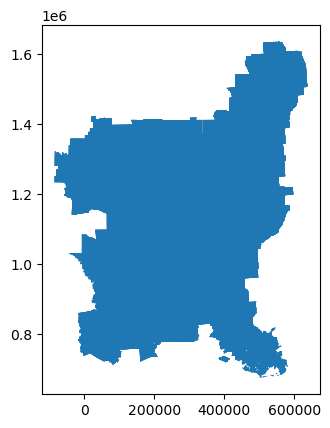

In [47]:
geoenergy[geoenergy['day']==1].plot()

In [50]:
trackenergy.to_csv('trackenergy.csv')